In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
train_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    shuffle = True,
    image_size = (299,299),
    batch_size = 32,
)

val_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    shuffle = True,
    image_size = (299,299),
    batch_size = 32,
)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


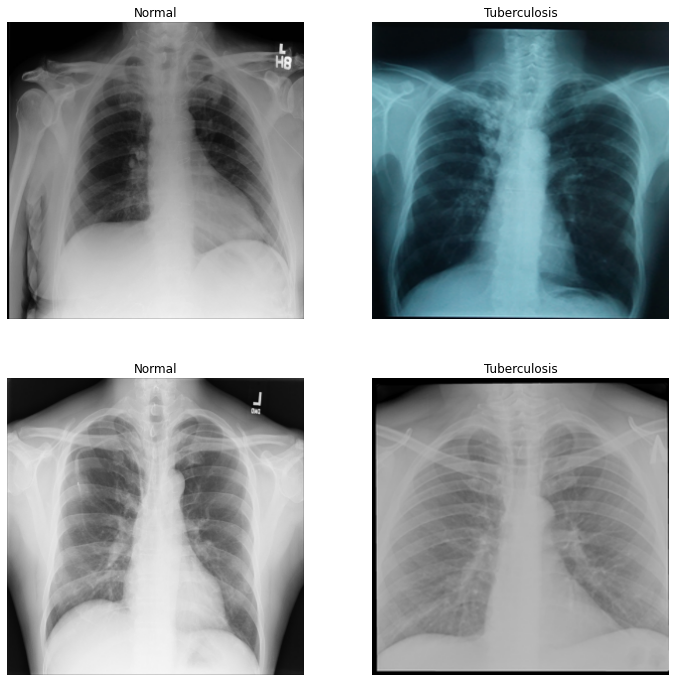

In [3]:
from tensorflow.data.experimental import cardinality

val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

class_names = train_ds.class_names

plt.figure(figsize=(12,12))
for images,labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomZoom, RandomRotation

data_augmentation = Sequential([
    RandomZoom(0.2),
    RandomRotation(0.1),
])

### Define the model

In [5]:
from tensorflow.keras.applications import inception_v3, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [6]:
rescale = inception_v3.preprocess_input

base_model = InceptionV3(input_shape=(299,299,3),include_top=False,weights="imagenet")
base_model.trainable = False
base_model.summary()


def model(input):
    x = data_augmentation(input)
    x = rescale(x)
    x = base_model(x,training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(2)(x)
    model = Model(input,outputs,name="Transfer_InceptionV3")
    return model

model = model(Input(shape=(299,299,3)))
model.summary()
model.compile(RMSprop(),SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

if __name__=="__main__":
    loss0,accuracy0 = model.evaluate(val_ds)
    print("Initial loss: {:.2f} %".format(100*loss0))
    print("Initial accuracy: {:.2f} %".format(100*accuracy0))
    checkpoint = ModelCheckpoint("tuberculosis.hdf5",save_weights_only=False,monitor="val_loss",save_best_only=True)
    model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("tuberculosis.hdf5")
    val_loss,val_accuracy = best.evaluate(val_ds)
    test_loss,test_accuracy = best.evaluate(test_ds)
    print("\nVal accuracy: {:.2f} %".format(100*val_accuracy))
    print("Val loss: {:.2f} %".format(100*val_loss))
    print("\nTest accuracy: {:.2f} %".format(100*test_accuracy))
    print("Test loss : {:.2f} %".format(100*test_loss))

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 